In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Each user is responsible for checking the content of datasets and the
# applicable licenses and determining if suitable for the intended use.


<img src="https://developer.download.nvidia.com/notebooks/dlsw-notebooks/merlin_transformers4rec_getting-started-session-based-02-session-based-xlnet-with-pyt/nvidia_logo.png" style="width: 90px; float: right;">

# Financial Product Binary Classification with XLNet


This notebook is created using the latest stable [merlin-pytorch](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/merlin/containers/merlin-pytorch/tags) container.

In this notebook we demonstrate binary classification for financial product recommendations using the [Transformers4Rec](https://github.com/NVIDIA-Merlin/Transformers4Rec) library. This notebook uses the PyTorch API and integrates with [HuggingFace's Transformers](https://github.com/huggingface/transformers) to implement the [XLNET](https://arxiv.org/abs/1906.08237) Transformer architecture for binary classification.

We build a model to predict whether a customer will convert for a top-up loan (`converts_for_a_topup`) based on their interaction sequences and profile features.


<img src="https://nvidia-merlin.github.io/Transformers4Rec/main/_images/transformers4rec_metaarchitecture.png">

In [2]:
# Configuration: Choose training approach
BALANCED_RATIO = 1 #10  # Must match the ratio used in notebook 01b

print("🎯 Training Configuration:")
print(f"   📊 Using balanced dataset with {BALANCED_RATIO}:1 ratio")
print(f"   🎯 This should provide better class balance for binary classification")

🎯 Training Configuration:
   📊 Using balanced dataset with 1:1 ratio
   🎯 This should provide better class balance for binary classification


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"


In [4]:
import glob
import torch 
import numpy as np
from sklearn.metrics import log_loss, roc_auc_score

from transformers4rec import torch as tr
from transformers4rec.torch.utils.examples_utils import wipe_memory


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [5]:
INPUT_DATA_DIR = os.environ.get("INPUT_DATA_DIR", "/workspace/data")
# Using classifier-specific datasets generated by notebook 01b (with converts_for_a_topup-max)
OUTPUT_DIR = os.environ.get("OUTPUT_DIR", f"{INPUT_DATA_DIR}/sessions_by_day_classifier")


In [6]:
from merlin.schema import Schema
from merlin.io import Dataset

train = Dataset(os.path.join(INPUT_DATA_DIR, "processed_nvt_classifier/part_0.parquet"))
schema = train.schema


/usr/local/lib/python3.8/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


In [7]:
schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,loan_id,(),"DType(name='int64', element_type=<ElementType....",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,day-first,(),"DType(name='int64', element_type=<ElementType....",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,product_interaction-list,"(Tags.LIST, Tags.ITEM, Tags.CATEGORICAL, Tags....","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.product_interaction.parquet,8.0,16.0,0.0,7.0,product_interaction,1.0,9.0
3,offer___carousel-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.offer___carousel.parquet,5.0,16.0,0.0,4.0,offer___carousel,1.0,9.0
4,servicing___carousel-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.servicing___carousel.parquet,5.0,16.0,0.0,4.0,servicing___carousel,1.0,9.0
5,feature_sheet-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.feature_sheet.parquet,5.0,16.0,0.0,4.0,feature_sheet,1.0,9.0
6,bottom_sheet-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.bottom_sheet.parquet,5.0,16.0,0.0,4.0,bottom_sheet,1.0,9.0
7,has_mobile_app-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.has_mobile_app.parquet,3.0,16.0,0.0,2.0,has_mobile_app,1.0,9.0
8,debtiq_enrolled-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.debtiq_enrolled.parquet,3.0,16.0,0.0,2.0,debtiq_enrolled,1.0,9.0
9,pa_eligible-list,"(Tags.CATEGORICAL, Tags.LIST)","DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.pa_eligible.parquet,3.0,16.0,0.0,2.0,pa_eligible,1.0,9.0


In [8]:
# Select FSI features for binary classification - predicting converts_for_a_topup
# and including both categorical and continuous features from the FSI dataset
schema = schema.select_by_name([
    'product_interaction-list',      # Main item sequence (offers + services combinations)
    'offer___carousel-list',         # Individual offer types
    'servicing___carousel-list',     # Individual service types  
    'feature_sheet-list',            # Feature sheet types
    'bottom_sheet-list',             # Bottom sheet types
    'has_mobile_app-list',           # Binary features
    'debtiq_enrolled-list',
    'pa_eligible-list',
    'topup_eligible-list',
    'ita_eligible-list',
    'fico-list',                     # Continuous features
    'income_-list',
    'existing_loan_size_-list',
    'current_loan_mob-list',
    'email_sent_in_last_90_days-list',
    'dm_sent_in_last_90_days-list',
    'converts_for_a_topup-max'      # Binary classification target
])


In [9]:
# Using smaller max_sequence_length for FSI financial data (sequences are typically shorter)
# No masking needed for binary classification
inputs = tr.TabularSequenceFeatures.from_schema(
        schema,
        max_sequence_length=10,  # Reduced for FSI data
        continuous_projection=64,
        d_output=100,
)


In [10]:
# For binary classification, we'll use the built-in log-loss from BinaryClassificationTask
# This avoids the complexity of custom metric implementations
print("Using built-in binary classification metrics from Transformers4Rec")


Using built-in binary classification metrics from Transformers4Rec


In [11]:
# Define XLNetConfig class and set default parameters for HF XLNet config  
# Updated total_seq_length to match FSI data sequence length
transformer_config = tr.XLNetConfig.build(
    d_model=64, n_head=4, n_layer=2, total_seq_length=10  # Reduced for FSI data
)

# Define the model block including: inputs, projection and transformer block
body = tr.SequentialBlock(
    inputs, 
    tr.MLPBlock([64]), 
    tr.TransformerBlock(transformer_config)
)

# Define a head for binary classification task 
# BinaryClassificationTask already includes log-loss metrics by default
head = tr.Head(
    body,
    tr.BinaryClassificationTask(
        target_name="converts_for_a_topup-max",
        task_name="conversion_prediction"
    ),
    inputs=inputs,
)

# Get the end-to-end Model class 
model = tr.Model(head)

print("Model created for binary classification with built-in log-loss metrics")


Model created for binary classification with built-in log-loss metrics


In [12]:
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

# Set training arguments
train_args = T4RecTrainingArguments(
    data_loader_engine='merlin', 
    dataloader_drop_last = True,
    gradient_accumulation_steps = 1,
    per_device_train_batch_size = 128, 
    per_device_eval_batch_size = 32,
    output_dir = "./tmp", 
    learning_rate=0.0005,
    lr_scheduler_type='cosine', 
    learning_rate_num_cosine_cycles_by_epoch=1.5,
    num_train_epochs=10,
    max_sequence_length=10,  # Updated for FSI data 
    report_to = [],
    logging_steps=50,
    no_cuda=False
)


In [13]:
# Instantiate the T4Rec Trainer
trainer = Trainer(
    model=model,
    args=train_args,
    schema=schema,
    compute_metrics=True,
)

# Function to extract metrics from trainer evaluation
def extract_metrics(eval_results, prefix='eval'):
    """Extract log-loss from evaluation results with flexible prefix"""
    log_loss_key = f'{prefix}_/loss'
    log_loss_val = eval_results.get(log_loss_key, None)
    return log_loss_val

# Store results for comparison
training_results = []


In [14]:
# ===============================
# BALANCED DATASET TRAINING
# ===============================
print("🎯 Starting training with balanced dataset approach...")

# Load balanced splits created in notebook 01b
balanced_dir = os.path.join(INPUT_DATA_DIR, f"balanced_classifier_ratio_{BALANCED_RATIO}_to_1")
train_path = os.path.join(balanced_dir, "train.parquet")
val_path = os.path.join(balanced_dir, "valid.parquet")
test_path = os.path.join(balanced_dir, "test.parquet")

if not all(os.path.exists(p) for p in [train_path, val_path, test_path]):
    raise FileNotFoundError(f"Balanced dataset splits not found. Run notebook 01b first.")

print(f"📊 Using balanced splits:")
print(f"   - Train: {train_path}")
print(f"   - Validation: {val_path}")
print(f"   - Test: {test_path}")

# Set training arguments optimized for balanced dataset
train_args.per_device_train_batch_size = 64  # Reduced batch size
train_args.num_train_epochs = 10
train_args.eval_strategy = "epoch"  # Evaluate every epoch
trainer.args = train_args

print('*'*50)
print("🚀 TRAINING WITH BALANCED DATASET")
print('*'*50)

# Single training session on balanced data
trainer.train_dataset_or_path = train_path
trainer.eval_dataset_or_path = val_path

trainer.train()
print('✅ Training finished')

# Final evaluation on validation set
print('\n' + '*'*30)
print("📊 VALIDATION RESULTS")
print('*'*30)

val_metrics = trainer.evaluate(metric_key_prefix='eval')
log_loss_val = extract_metrics(val_metrics, prefix='eval')

for key in sorted(val_metrics.keys()):
    print(f" {key} = {str(val_metrics[key])}")

print(f"\n📈 Validation Metrics:")
if log_loss_val is not None:
    print(f"   - Log-Loss: {log_loss_val:.4f}")
else:
    print(f"   - Log-Loss: Not available")

# Final evaluation on test set
print('\n' + '*'*30)
print("🎯 TEST RESULTS")
print('*'*30)

trainer.eval_dataset_or_path = test_path
test_metrics = trainer.evaluate(metric_key_prefix='test')
test_log_loss = extract_metrics(test_metrics, prefix='test')

for key in sorted(test_metrics.keys()):
    print(f" {key} = {str(test_metrics[key])}")

print(f"\n🏆 Final Test Metrics:")
if test_log_loss is not None:
    print(f"   - Log-Loss: {test_log_loss:.4f}")
else:
    print(f"   - Log-Loss: Not available")

# Store results
training_results.append({
    'approach': 'balanced_dataset',
    'split': 'validation',
    'log_loss': log_loss_val,
})

training_results.append({
    'approach': 'balanced_dataset', 
    'split': 'test',
    'log_loss': test_log_loss,
})

print("🎯 Training completed!")


🎯 Starting training with balanced dataset approach...
📊 Using balanced splits:
   - Train: /workspace/data/balanced_classifier_ratio_1_to_1/train.parquet
   - Validation: /workspace/data/balanced_classifier_ratio_1_to_1/valid.parquet
   - Test: /workspace/data/balanced_classifier_ratio_1_to_1/test.parquet
**************************************************
🚀 TRAINING WITH BALANCED DATASET
**************************************************


***** Running training *****
  Num examples = 4736
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 740


Step,Training Loss
50,0.461800
100,0.381300
150,0.343400
200,0.346300
250,0.336100
300,0.336200
350,0.339100
400,0.316900
450,0.323600
500,0.325300


Saving model checkpoint to ./tmp/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Training completed. Do not forget to share your model on huggingface.co/models =)




✅ Training finished

******************************
📊 VALIDATION RESULTS
******************************


 eval_/conversion_prediction/binary_accuracy = 0.8544921875
 eval_/conversion_prediction/binary_precision = 0.7788018584251404
 eval_/conversion_prediction/binary_recall = 0.990234375
 eval_/loss = 0.34343916177749634
 eval_runtime = 0.9028
 eval_samples_per_second = 1134.198
 eval_steps_per_second = 35.444

📈 Validation Metrics:
   - Log-Loss: 0.3434

******************************
🎯 TEST RESULTS
******************************
 test_/conversion_prediction/binary_accuracy = 0.8505859375
 test_/conversion_prediction/binary_precision = 0.7765793800354004
 test_/conversion_prediction/binary_recall = 0.984375
 test_/loss = 0.35857677459716797
 test_runtime = 0.9762
 test_samples_per_second = 1048.953
 test_steps_per_second = 32.78

🏆 Final Test Metrics:
   - Log-Loss: 0.3586
🎯 Training completed!


In [15]:
# Results Summary
import pandas as pd

results_df = pd.DataFrame(training_results)
print("="*80)
print("TRANSFORMER BINARY CLASSIFICATION RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Calculate average performance for log-loss (always available)
valid_log_loss_results = results_df.dropna(subset=['log_loss'])
if len(valid_log_loss_results) > 0:
    avg_log_loss = valid_log_loss_results['log_loss'].mean()
    
    print(f"\n📊 Average Performance:")
    print(f"   - Average Log-Loss: {avg_log_loss:.4f}")
        
    # Compare with rule-based baseline (from notebook 00)
    baseline_log_loss = 1.020  # From rule-based model
    
    print(f"\n🔄 Comparison with Rule-Based Baseline:")
    print(f"   - Log-Loss: {avg_log_loss:.4f} vs {baseline_log_loss:.3f} (baseline)")
    
    log_loss_improvement = ((baseline_log_loss - avg_log_loss) / baseline_log_loss) * 100
    
    print(f"   - Log-Loss improvement: {log_loss_improvement:+.1f}%")
    
    if avg_log_loss < baseline_log_loss:
        print("✅ Transformer model outperforms rule-based baseline on Log-Loss")

print("\n🎯 Training completed successfully!")


TRANSFORMER BINARY CLASSIFICATION RESULTS SUMMARY
        approach      split  log_loss
balanced_dataset validation  0.343439
balanced_dataset       test  0.358577

📊 Average Performance:
   - Average Log-Loss: 0.3510

🔄 Comparison with Rule-Based Baseline:
   - Log-Loss: 0.3510 vs 1.020 (baseline)
   - Log-Loss improvement: +65.6%
✅ Transformer model outperforms rule-based baseline on Log-Loss

🎯 Training completed successfully!


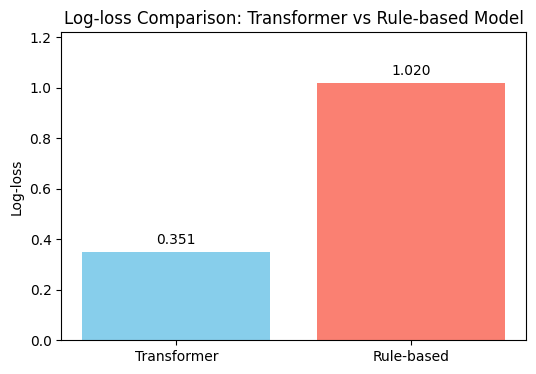

In [17]:
import matplotlib.pyplot as plt

# Data
models = ['Transformer', 'Rule-based']
log_loss = [0.3510, 1.020]

# Create bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(models, log_loss, color=['skyblue', 'salmon'])
plt.ylabel('Log-loss')
plt.title('Log-loss Comparison: Transformer vs Rule-based Model')

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(log_loss) + 0.2)
plt.show()

In [16]:
# Save the model
model_path = os.path.join(INPUT_DATA_DIR, "saved_model_binary_classification")
model.save(model_path)
print(f"Model saved to: {model_path}")

print("\n## Summary")
print("✅ Successfully trained a binary classification model using Transformers4Rec!")
print("📊 Predicted customer conversion for top-up loans")
print("🔗 Evaluated using log-loss metrics")
print("📈 Compared performance against rule-based baseline")


Model saved to: /workspace/data/saved_model_binary_classification

## Summary
✅ Successfully trained a binary classification model using Transformers4Rec!
📊 Predicted customer conversion for top-up loans
🔗 Evaluated using log-loss metrics
📈 Compared performance against rule-based baseline
